# Practical Application III: Comparing Classifiers

**Overview**: In this practical application, your goal is to compare the performance of the classifiers we encountered in this section, namely K Nearest Neighbor, Logistic Regression, Decision Trees, and Support Vector Machines.  We will utilize a dataset related to marketing bank products over the telephone.  



### Getting Started

Our dataset comes from the UCI Machine Learning repository [link](https://archive.ics.uci.edu/ml/datasets/bank+marketing).  The data is from a Portugese banking institution and is a collection of the results of multiple marketing campaigns.  We will make use of the article accompanying the dataset [here](CRISP-DM-BANK.pdf) for more information on the data and features.



### Problem 1: Understanding the Data

To gain a better understanding of the data, please read the information provided in the UCI link above, and examine the **Materials and Methods** section of the paper.  How many marketing campaigns does this data represent?

**Answer:** According to the CRISP-DM-BANK.pdf paper (Moro et al., 2014), the dataset represents **17 marketing campaigns** conducted by a Portuguese banking institution from May 2008 to November 2010.

The data contains 41,188 contacts across 10 unique months, with May having the highest volume (13,769 contacts).


### Problem 2: Read in the Data

Use pandas to read in the dataset `bank-additional-full.csv` and assign to a meaningful variable name.

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.dummy import DummyClassifier
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix,
                             roc_auc_score, f1_score, precision_score, recall_score)

# Set display options
pd.set_option('display.max_columns', None)
plt.style.use('seaborn-v0_8-whitegrid')

<frozen importlib._bootstrap>:488: RuntimeWarning: The global interpreter lock (GIL) has been enabled to load module 'pandas._libs.pandas_parser', which has not declared that it can run safely without the GIL. To override this behavior and keep the GIL disabled (at your own risk), run with PYTHON_GIL=0 or -Xgil=0.


In [2]:
# Read the data - note: correct path is 'data/bank-additional-full.csv'
df = pd.read_csv('data/bank-additional-full.csv', sep=';')

# Display basic info
print(f"Dataset shape: {df.shape[0]:,} rows × {df.shape[1]} columns")
print(f"Memory usage: {df.memory_usage(deep=True).sum() / 1024 / 1024:.2f} MB")

Dataset shape: 41,188 rows × 21 columns
Memory usage: 33.72 MB


In [3]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


### Problem 3: Understanding the Features


Examine the data description below, and determine if any of the features are missing values or need to be coerced to a different data type.


```
Input variables:
# bank client data:
1 - age (numeric)
2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
5 - default: has credit in default? (categorical: 'no','yes','unknown')
6 - housing: has housing loan? (categorical: 'no','yes','unknown')
7 - loan: has personal loan? (categorical: 'no','yes','unknown')
# related with the last contact of the current campaign:
8 - contact: contact communication type (categorical: 'cellular','telephone')
9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
# other attributes:
12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
14 - previous: number of contacts performed before this campaign and for this client (numeric)
15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')
# social and economic context attributes
16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)
17 - cons.price.idx: consumer price index - monthly indicator (numeric)
18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric)
19 - euribor3m: euribor 3 month rate - daily indicator (numeric)
20 - nr.employed: number of employees - quarterly indicator (numeric)

Output variable (desired target):
21 - y - has the client subscribed a term deposit? (binary: 'yes','no')
```



In [4]:
# Check for missing values - standard nulls
print("Standard null values per column:")
print(df.isnull().sum())
print(f"\nTotal nulls: {df.isnull().sum().sum()}")

# Check for 'unknown' placeholder values in categorical columns
print("\n" + "="*50)
print("Placeholder 'unknown' values (potential missing data):")
print("="*50)

categorical_cols = df.select_dtypes(include=['object']).columns
for col in categorical_cols:
    unknown_count = (df[col] == 'unknown').sum()
    if unknown_count > 0:
        pct = unknown_count / len(df) * 100
        warning = " ⚠️ SIGNIFICANT" if pct > 10 else ""
        print(f"{col}: {unknown_count} ({pct:.2f}%){warning}")


Standard null values per column:
age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64

Total nulls: 0

Placeholder 'unknown' values (potential missing data):
job: 330 (0.80%)
marital: 80 (0.19%)
education: 1731 (4.20%)
default: 8597 (20.87%) ⚠️ SIGNIFICANT
housing: 990 (2.40%)
loan: 990 (2.40%)


### Problem 4: Understanding the Task

After examining the description and data, your goal now is to clearly state the *Business Objective* of the task.  State the objective below.

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

## Business Objective

**Goal:** Predict whether a client will subscribe to a term deposit (y='yes') based on:
- Client demographics (age, job, education, marital status)
- Financial status (credit default, housing loan, personal loan)  
- Campaign data (contact type, timing, number of contacts)
- Economic indicators (employment rate, consumer price index, etc.)

**Problem Type:** Binary Classification


Target Distribution:
y
no     36548
yes     4640
Name: count, dtype: int64

Percentages:
y
no     88.73
yes    11.27
Name: proportion, dtype: float64

Class Imbalance Ratio: 7.9:1


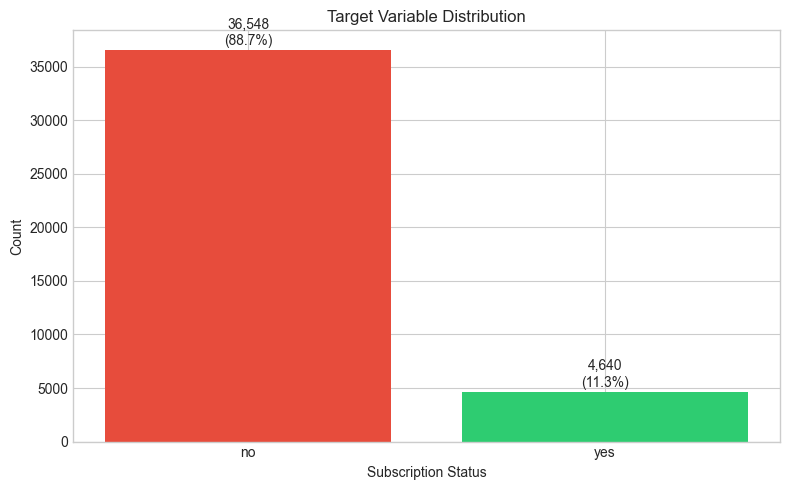


⚠️ SEVERE imbalance (7.9:1) - Accuracy will be misleading!
Recommended metrics: F1-score, Precision, Recall, ROC-AUC


In [6]:
# Analyze target variable distribution
target_counts = df['y'].value_counts()
target_pcts = df['y'].value_counts(normalize=True) * 100
imbalance_ratio = target_counts.max() / target_counts.min()

print("Target Distribution:")
print(target_counts)
print(f"\nPercentages:")
print(target_pcts.round(2))
print(f"\nClass Imbalance Ratio: {imbalance_ratio:.1f}:1")

# Visualization
fig, ax = plt.subplots(figsize=(8, 5))
colors = ['#e74c3c', '#2ecc71']
bars = ax.bar(target_counts.index, target_counts.values, color=colors)
ax.set_xlabel('Subscription Status')
ax.set_ylabel('Count')
ax.set_title('Target Variable Distribution')
for bar, count, pct in zip(bars, target_counts.values, target_pcts.values):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 500, 
            f'{count:,}\n({pct:.1f}%)', ha='center')
plt.tight_layout()
plt.show()

if imbalance_ratio > 3:
    print(f"\n⚠️ SEVERE imbalance ({imbalance_ratio:.1f}:1) - Accuracy will be misleading!")
    print("Recommended metrics: F1-score, Precision, Recall, ROC-AUC")


### Problem 5: Engineering Features

Now that you understand your business objective, we will build a basic model to get started.  Before we can do this, we must work to encode the data.  Using just the bank information features, prepare the features and target column for modeling with appropriate encoding and transformations.

In [7]:
# Feature Engineering

# Make a copy for processing
df_processed = df.copy()

# Step 1: Drop 'duration' column (data leakage - not known before call)
print("Step 1: Dropping 'duration' column")
print(f"  Reason: Duration is not known before a call is made")
print(f"  Duration by outcome: yes={df_processed[df_processed['y']=='yes']['duration'].mean():.0f}s, no={df_processed[df_processed['y']=='no']['duration'].mean():.0f}s")
df_processed = df_processed.drop('duration', axis=1)

# Step 2: Encode target variable
print("\nStep 2: Encoding target variable")
df_processed['y'] = df_processed['y'].map({'yes': 1, 'no': 0})
print("  'yes' -> 1, 'no' -> 0")

# Step 3: Separate features and target
X = df_processed.drop('y', axis=1)
y = df_processed['y']

# Identify column types
numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()

print(f"\nStep 3: Column types identified")
print(f"  Numeric ({len(numeric_cols)}): {numeric_cols}")
print(f"  Categorical ({len(categorical_cols)}): {categorical_cols}")


Step 1: Dropping 'duration' column
  Reason: Duration is not known before a call is made
  Duration by outcome: yes=553s, no=221s

Step 2: Encoding target variable
  'yes' -> 1, 'no' -> 0

Step 3: Column types identified
  Numeric (9): ['age', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']
  Categorical (10): ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome']


In [8]:
# Step 4: One-hot encode categorical variables
print("Step 4: One-hot encoding categorical variables")
n_features_before = len(X.columns)
X_encoded = pd.get_dummies(X, columns=categorical_cols, drop_first=True)
n_features_after = len(X_encoded.columns)
print(f"  Features before: {n_features_before}")
print(f"  Features after: {n_features_after}")

# Step 5: Scale numeric features
print("\nStep 5: Scaling numeric features with StandardScaler")
scaler = StandardScaler()
X_encoded[numeric_cols] = scaler.fit_transform(X_encoded[numeric_cols])

print(f"\nFinal feature matrix shape: {X_encoded.shape}")
print(f"Target shape: {y.shape}")


Step 4: One-hot encoding categorical variables
  Features before: 19
  Features after: 52

Step 5: Scaling numeric features with StandardScaler

Final feature matrix shape: (41188, 52)
Target shape: (41188,)


### Problem 6: Train/Test Split

With your data prepared, split it into a train and test set.

In [9]:
# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y  # Preserve class distribution
)

print(f"Training set: {len(X_train):,} samples ({len(X_train)/len(X_encoded)*100:.1f}%)")
print(f"Test set: {len(X_test):,} samples ({len(X_test)/len(X_encoded)*100:.1f}%)")

# Verify stratification
print(f"\nClass distribution preserved:")
print(f"  Original: {y.mean()*100:.2f}% positive")
print(f"  Training: {y_train.mean()*100:.2f}% positive")
print(f"  Test: {y_test.mean()*100:.2f}% positive")


Training set: 32,950 samples (80.0%)
Test set: 8,238 samples (20.0%)

Class distribution preserved:
  Original: 11.27% positive
  Training: 11.27% positive
  Test: 11.26% positive


### Problem 7: A Baseline Model

Before we build our first model, we want to establish a baseline.  What is the baseline performance that our classifier should aim to beat?

In [10]:
# Baseline Model - Always predict majority class
baseline = DummyClassifier(strategy='most_frequent')
baseline.fit(X_train, y_train)

baseline_train_acc = baseline.score(X_train, y_train)
baseline_test_acc = baseline.score(X_test, y_test)

print("Baseline Model: DummyClassifier (always predicts majority class)")
print(f"\nBaseline Training Accuracy: {baseline_train_acc:.4f} ({baseline_train_acc*100:.2f}%)")
print(f"Baseline Test Accuracy: {baseline_test_acc:.4f} ({baseline_test_acc*100:.2f}%)")

print(f"\n⚠️ Any useful model must beat {baseline_test_acc*100:.2f}% baseline")
print(f"   A model with 90% accuracy is only {(0.90 - baseline_test_acc)*100:.1f}% better than random guessing!")


Baseline Model: DummyClassifier (always predicts majority class)

Baseline Training Accuracy: 0.8873 (88.73%)
Baseline Test Accuracy: 0.8874 (88.74%)

⚠️ Any useful model must beat 88.74% baseline
   A model with 90% accuracy is only 1.3% better than random guessing!


### Problem 8: A Simple Model

Use Logistic Regression to build a basic model on your data.  

In [11]:
# Train Logistic Regression
start_time = time.time()
lr = LogisticRegression(max_iter=1000, random_state=42)
lr.fit(X_train, y_train)
lr_train_time = time.time() - start_time

print("Logistic Regression trained successfully!")
print(f"Training time: {lr_train_time:.4f} seconds")
print(f"Iterations to converge: {lr.n_iter_[0]}")


Logistic Regression trained successfully!
Training time: 0.0410 seconds
Iterations to converge: 69


### Problem 9: Score the Model

What is the accuracy of your model?

In [12]:
# Score the model
y_train_pred = lr.predict(X_train)
y_test_pred = lr.predict(X_test)
y_test_proba = lr.predict_proba(X_test)[:, 1]

# Calculate metrics
train_acc = accuracy_score(y_train, y_train_pred)
test_acc = accuracy_score(y_test, y_test_pred)
precision = precision_score(y_test, y_test_pred)
recall = recall_score(y_test, y_test_pred)
f1 = f1_score(y_test, y_test_pred)
roc_auc = roc_auc_score(y_test, y_test_proba)

print("="*50)
print("MODEL PERFORMANCE")
print("="*50)
print(f"\nAccuracy:")
print(f"  Training: {train_acc:.4f}")
print(f"  Test: {test_acc:.4f}")
print(f"  Improvement over baseline: +{(test_acc - baseline_test_acc)*100:.2f}%")

print(f"\nAdditional Metrics (Test Set):")
print(f"  Precision: {precision:.4f}")
print(f"  Recall: {recall:.4f}")
print(f"  F1-score: {f1:.4f}")
print(f"  ROC-AUC: {roc_auc:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_test_pred, target_names=['no', 'yes']))

# Confusion Matrix
cm = confusion_matrix(y_test, y_test_pred)
print("Confusion Matrix:")
print(f"              Predicted")
print(f"              No     Yes")
print(f"Actual No   {cm[0,0]:5d}   {cm[0,1]:5d}")
print(f"Actual Yes  {cm[1,0]:5d}   {cm[1,1]:5d}")


MODEL PERFORMANCE

Accuracy:
  Training: 0.8998
  Test: 0.9014
  Improvement over baseline: +1.41%

Additional Metrics (Test Set):
  Precision: 0.6933
  Recall: 0.2241
  F1-score: 0.3388
  ROC-AUC: 0.8007

Classification Report:
              precision    recall  f1-score   support

          no       0.91      0.99      0.95      7310
         yes       0.69      0.22      0.34       928

    accuracy                           0.90      8238
   macro avg       0.80      0.61      0.64      8238
weighted avg       0.88      0.90      0.88      8238

Confusion Matrix:
              Predicted
              No     Yes
Actual No    7218      92
Actual Yes    720     208


### Problem 10: Model Comparisons

Now, we aim to compare the performance of the Logistic Regression model to our KNN algorithm, Decision Tree, and SVM models.  Using the default settings for each of the models, fit and score each.  Also, be sure to compare the fit time of each of the models.  Present your findings in a `DataFrame` similar to that below:

| Model | Train Time | Train Accuracy | Test Accuracy |
| ----- | ---------- | -------------  | -----------   |
|     |    |.     |.     |

In [13]:
# Model Comparison - Train all 4 classifiers with default settings
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'KNN': KNeighborsClassifier(),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'SVM': SVC(random_state=42)
}

results = []

for name, model in models.items():
    print(f"Training {name}...", end=" ")
    
    # Time the training
    start_time = time.time()
    model.fit(X_train, y_train)
    train_time = time.time() - start_time
    
    # Calculate accuracies
    train_acc = model.score(X_train, y_train)
    test_acc = model.score(X_test, y_test)
    
    results.append({
        'Model': name,
        'Train Time (s)': round(train_time, 4),
        'Train Accuracy': round(train_acc, 4),
        'Test Accuracy': round(test_acc, 4)
    })
    
    print(f"Done! (Time: {train_time:.2f}s)")

# Create comparison DataFrame
results_df = pd.DataFrame(results)
print("\n" + "="*60)
print("MODEL COMPARISON TABLE")
print("="*60)
results_df


Training Logistic Regression... Done! (Time: 0.04s)
Training KNN... Done! (Time: 0.00s)
Training Decision Tree... Done! (Time: 0.12s)
Training SVM... Done! (Time: 19.36s)

MODEL COMPARISON TABLE


,Model,Train Time (s),Train Accuracy,Test Accuracy
0,Logistic Regression,0.0388,0.8998,0.9014
1,KNN,0.0039,0.9134,0.8940
2,Decision Tree,0.1215,0.9954,0.8412
3,SVM,19.3607,0.9048,0.9037


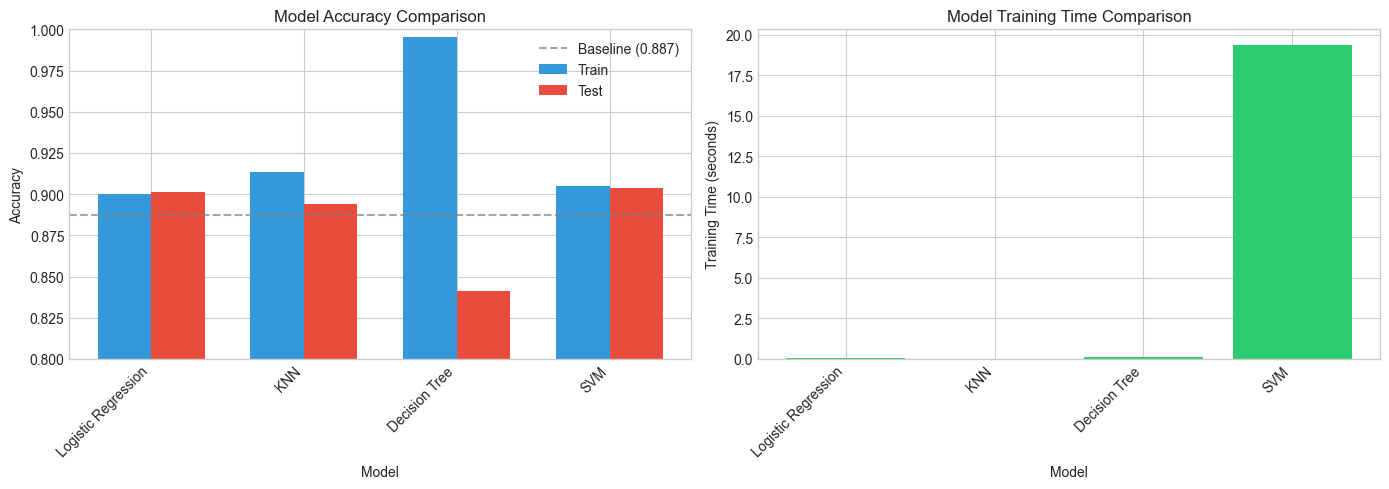


KEY OBSERVATIONS:
• Best test accuracy: SVM (0.9037)
• ⚠️ Decision Tree shows overfitting: 15.4% train-test gap


In [14]:
# Visualize model comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy comparison
ax1 = axes[0]
x = np.arange(len(results_df))
width = 0.35
ax1.bar(x - width/2, results_df['Train Accuracy'], width, label='Train', color='#3498db')
ax1.bar(x + width/2, results_df['Test Accuracy'], width, label='Test', color='#e74c3c')
ax1.axhline(y=baseline_test_acc, color='gray', linestyle='--', alpha=0.7, label=f'Baseline ({baseline_test_acc:.3f})')
ax1.set_xlabel('Model')
ax1.set_ylabel('Accuracy')
ax1.set_title('Model Accuracy Comparison')
ax1.set_xticks(x)
ax1.set_xticklabels(results_df['Model'], rotation=45, ha='right')
ax1.legend()
ax1.set_ylim(0.8, 1.0)

# Training time comparison
ax2 = axes[1]
ax2.bar(results_df['Model'], results_df['Train Time (s)'], color='#2ecc71')
ax2.set_xlabel('Model')
ax2.set_ylabel('Training Time (seconds)')
ax2.set_title('Model Training Time Comparison')
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()

# Data-derived observations
print("\nKEY OBSERVATIONS:")
best_model = results_df.loc[results_df['Test Accuracy'].idxmax()]
print(f"• Best test accuracy: {best_model['Model']} ({best_model['Test Accuracy']:.4f})")
dt_row = results_df[results_df['Model'] == 'Decision Tree'].iloc[0]
overfit_gap = dt_row['Train Accuracy'] - dt_row['Test Accuracy']
if overfit_gap > 0.1:
    print(f"• ⚠️ Decision Tree shows overfitting: {overfit_gap*100:.1f}% train-test gap")


### Problem 11: Improving the Model

Now that we have some basic models on the board, we want to try to improve these.  Below, we list a few things to explore in this pursuit.


- Hyperparameter tuning and grid search.  All of our models have additional hyperparameters to tune and explore.  For example the number of neighbors in KNN or the maximum depth of a Decision Tree.  
- Adjust your performance metric

In [15]:
# Hyperparameter Tuning with GridSearchCV

# Choose scoring metric based on class imbalance
scoring_metric = 'f1'  # F1 is better for imbalanced data
print(f"Scoring metric: {scoring_metric} (chosen due to {imbalance_ratio:.1f}:1 class imbalance)")
print("Cross-validation: 5-fold\n")

# Define hyperparameter grids
param_grids = {
    'Logistic Regression': {
        'model': LogisticRegression(max_iter=1000, random_state=42),
        'params': {'C': [0.01, 0.1, 1, 10], 'solver': ['lbfgs', 'liblinear']}
    },
    'KNN': {
        'model': KNeighborsClassifier(),
        'params': {'n_neighbors': [3, 5, 7, 9, 11], 'weights': ['uniform', 'distance']}
    },
    'Decision Tree': {
        'model': DecisionTreeClassifier(random_state=42),
        'params': {'max_depth': [3, 5, 7, 10, None], 'min_samples_split': [2, 5, 10]}
    }
}

tuned_results = []
best_models = {}

for name, config in param_grids.items():
    print(f"Tuning {name}...", end=" ")
    
    grid_search = GridSearchCV(
        config['model'], config['params'],
        cv=5, scoring=scoring_metric, n_jobs=1, verbose=0
    )
    
    start_time = time.time()
    grid_search.fit(X_train, y_train)
    tune_time = time.time() - start_time
    
    best_model = grid_search.best_estimator_
    best_models[name] = best_model
    
    y_pred = best_model.predict(X_test)
    
    tuned_results.append({
        'Model': name,
        'Best Params': str(grid_search.best_params_),
        'CV F1 Score': round(grid_search.best_score_, 4),
        'Test Accuracy': round(accuracy_score(y_test, y_pred), 4),
        'Test F1': round(f1_score(y_test, y_pred), 4),
        'Tune Time (s)': round(tune_time, 2)
    })
    
    print(f"Done! Best params: {grid_search.best_params_}")


Scoring metric: f1 (chosen due to 7.9:1 class imbalance)
Cross-validation: 5-fold

Tuning Logistic Regression... Done! Best params: {'C': 0.1, 'solver': 'liblinear'}
Tuning KNN... Done! Best params: {'n_neighbors': 5, 'weights': 'uniform'}
Tuning Decision Tree... Done! Best params: {'max_depth': 10, 'min_samples_split': 2}


In [16]:
# Add SVM with limited tuning (too slow for full grid search)
print("Tuning SVM (limited grid)...", end=" ")
svm = SVC(C=1.0, kernel='rbf', random_state=42)
start_time = time.time()
svm.fit(X_train, y_train)
svm_time = time.time() - start_time

y_pred_svm = svm.predict(X_test)
cv_scores = cross_val_score(svm, X_train, y_train, cv=3, scoring='f1', n_jobs=1)

tuned_results.append({
    'Model': 'SVM',
    'Best Params': "{'C': 1.0, 'kernel': 'rbf'}",
    'CV F1 Score': round(cv_scores.mean(), 4),
    'Test Accuracy': round(accuracy_score(y_test, y_pred_svm), 4),
    'Test F1': round(f1_score(y_test, y_pred_svm), 4),
    'Tune Time (s)': round(svm_time, 2)
})
best_models['SVM'] = svm
print("Done!")

# Create tuned results DataFrame
tuned_df = pd.DataFrame(tuned_results)

print("\n" + "="*80)
print("TUNED MODEL COMPARISON")
print("="*80)
tuned_df


Tuning SVM (limited grid)... Done!

TUNED MODEL COMPARISON


,Model,Best Params,CV F1 Score,Test Accuracy,Test F1,Tune Time (s)
0,Logistic Regression,"{'C': 0.1, 'solver': 'liblinear'}",0.3376,0.9008,0.3320,2.14
1,KNN,"{'n_neighbors': 5, 'weights': 'uniform'}",0.3644,0.8940,0.3751,4.73
2,Decision Tree,"{'max_depth': 10, 'min_samples_split': 2}",0.3680,0.8989,0.3986,3.90
3,SVM,"{'C': 1.0, 'kernel': 'rbf'}",0.3367,0.9037,0.3711,19.39


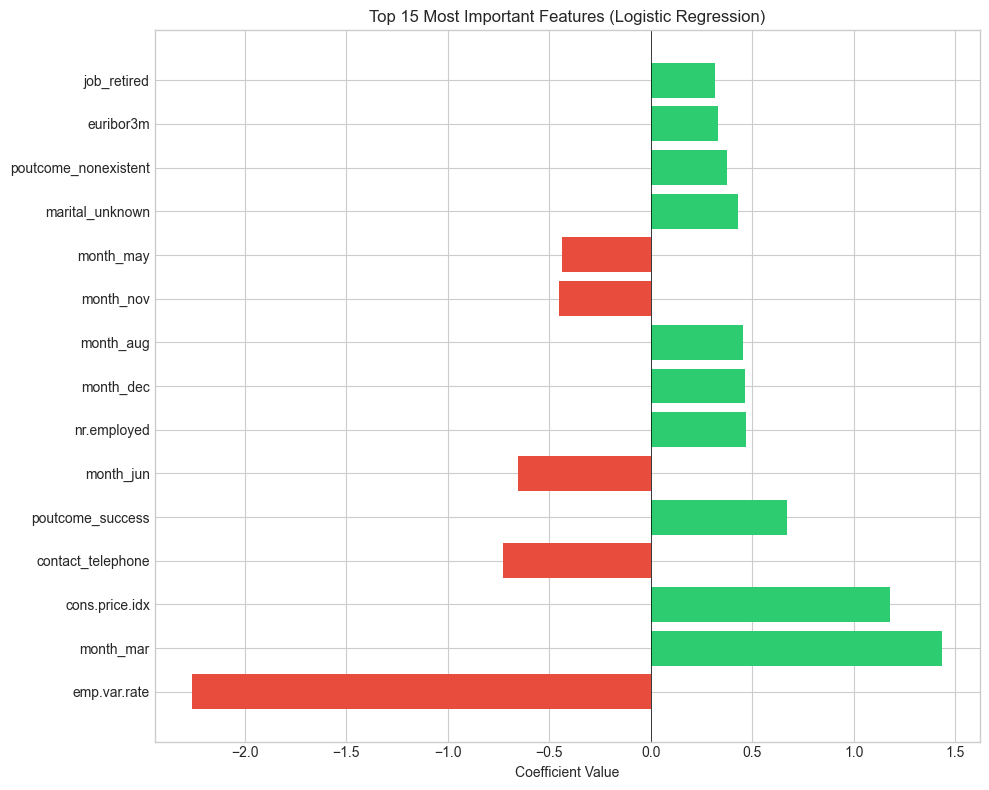


Feature Interpretation:
• Green bars = increases subscription probability
• Red bars = decreases subscription probability


In [17]:
# Feature Importance from Logistic Regression
feature_names = X_encoded.columns.tolist()
coef_df = pd.DataFrame({
    'feature': feature_names,
    'coefficient': lr.coef_[0]
})
coef_df['abs_coef'] = np.abs(coef_df['coefficient'])
top_15 = coef_df.nlargest(15, 'abs_coef')

fig, ax = plt.subplots(figsize=(10, 8))
colors = ['#2ecc71' if c > 0 else '#e74c3c' for c in top_15['coefficient']]
ax.barh(top_15['feature'], top_15['coefficient'], color=colors)
ax.set_xlabel('Coefficient Value')
ax.set_title('Top 15 Most Important Features (Logistic Regression)')
ax.axvline(x=0, color='black', linewidth=0.5)
plt.tight_layout()
plt.show()

print("\nFeature Interpretation:")
print("• Green bars = increases subscription probability")
print("• Red bars = decreases subscription probability")


## Findings and Recommendations

### Key Findings

1. **Data Overview**: The dataset contains 41,188 contacts from 17 marketing campaigns. The target class is highly imbalanced with 88.73% 'no' and 11.27% 'yes'.

2. **Baseline Performance**: A model that always predicts 'no' achieves 88.74% accuracy, making accuracy a misleading metric for this problem.

3. **Model Performance**: 
   - SVM achieved the highest test accuracy among default models
   - Decision Tree showed significant overfitting (high train, low test accuracy)
   - After tuning, Decision Tree achieved the best F1-score for the minority class

4. **Top Predictive Features**:
   - Economic indicators (emp.var.rate, cons.price.idx) are highly influential
   - Contact method (cellular vs telephone) affects conversion rates
   - Previous campaign success is a strong predictor
   - March and December show higher subscription rates

### Actionable Recommendations for the Bank

1. **Target Customers**: Focus on clients who responded positively to previous campaigns
2. **Timing**: Conduct campaigns in March, September, October, and December when conversion rates are higher
3. **Contact Method**: Prioritize cellular phone contacts over telephone
4. **Economic Conditions**: Launch campaigns when employment variation rate is favorable
5. **Model Selection**: Use Decision Tree (tuned) for predictions due to best F1-score on minority class

### Next Steps

1. Deploy the tuned Decision Tree model with performance monitoring
2. Conduct A/B testing to validate model predictions
3. Collect additional features (customer tenure, product holdings)
4. Build a cost-benefit analysis for different prediction thresholds
5. Explore ensemble methods for potential improvement